In [1]:
import sys
if 'google.colab' in sys.modules:
    # Install pyg-lib for accelerated neighborhood sampling
    # NOTE: Make sure you are using the correct torch version
    # https://pytorch.org/get-started/locally/
    # Install torch_geometric and its dependencies
    import os
    import torch

    # Install torch-scatter and torch-sparse
    # NOTE: Make sure you are using the correct torch version
    # https://pytorch.org/get-started/locally/
    TORCH = torch.__version__.split('+')[0]
    CUDA = 'cu' + torch.version.cuda.replace('.', '')

    !pip install torch-scatter -f https://data.pyg.org/whl/torch-{TORCH}+{CUDA}.html
    !pip install torch-sparse -f https://data.pyg.org/whl/torch-{TORCH}+{CUDA}.html
    !pip install torch_geometric
    TORCH = torch.__version__.split('+')[0]
    CUDA = 'cu' + torch.version.cuda.replace('.', '')

    !pip install pyg-lib -f https://data.pyg.org/whl/torch-{TORCH}+{CUDA}.html

Looking in links: https://data.pyg.org/whl/torch-2.8.0+cu126.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 110.2 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/torch-2.8.0+cu126.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 80.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 36.1 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/torch-2.8.0+cu126.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 67.5 MB/s eta 0:00:00


In [2]:
import sys
import os

# Run this only if running on Colab
if 'google.colab' in sys.modules:
    repo_dir = 'project273a'
    if not os.path.exists(repo_dir):
        !git clone https://github.com/carloea2/project273a.git
    %cd {repo_dir}
    !git pull origin master # Pull the latest changes from the master branch
    sys.path.append('/content/project273a')

/content/project273a
From https://github.com/carloea2/project273a
 * branch            master     -> FETCH_HEAD
Updating 22a8c28..94c1e55
Fast-forward
 train/evaluation.py | 232 +++++++++++++++++++++++++---------------------------
 1 file changed, 112 insertions(+), 120 deletions(-)


In [2]:
%load_ext autoreload
%autoreload 1

ModuleNotFoundError: No module named 'imp'

In [3]:
# Imports for utilities
import os

from utils.config import Config  # Pydantic data model for config
from utils.logging import init_logging
from utils.seed import set_seed

# Define configuration as a nested dictionary (or use JSON format)
config_dict = {
    "system": {
        "numexpr_threads": 4,
        "deterministic": False,
        "cpu": {
          "intra_op_threads": None,
          "inter_op_threads": None,
          "omp_num_threads": None,
          "mkl_num_threads": None,
          "kmp_affinity": "granularity=fine,compact,1,0",
          "start_method": "forkserver",
          "pin_affinity_cores": None
        },
        "dataloader": {
          "num_workers": os.cpu_count()//2,           # auto -> max(2, cores-1)
          "prefetch_factor": 4,
          "persistent_workers": True,
          "pin_memory": True,
          "pin_memory_device": "cuda",
          "non_blocking": True
        },
        "cuda": {
          "enabled": True,
          "device_ids": None,            # auto -> all visible
          "allow_tf32": True,
          "matmul_precision": "high",
          "cudnn_benchmark": True,
          "cudnn_deterministic": None,
          "amp": False,
          "amp_dtype": "bf16",           # prefer bf16 on Ampere+ if available
          "grad_scaler_enabled": True,
          "compile_mode": "reduce-overhead",
          "compile_fullgraph": True,
          "uva": True
        },
        "ddp": {
          "enabled": False,
          "backend": "nccl",
          "find_unused_parameters": False,
          "gradient_as_bucket_view": True,
          "broadcast_buffers": False,
          "static_graph": False
        }
    },
    "data": {
        "csv_path": "raw/diabetic_data.csv",            # raw data file
        "ids_mapping_path": "raw/IDS_mapping.csv",          # ID mapping file for codes
        "target": {"name": "readmitted", "positive_values": ["<30"], "binarized_name": "readmitted_binary"},  # predict 30-day readmit
        "identifier_cols": {"encounter_id": "encounter_id", "patient_id": "patient_nbr"},
        "filters": {
            "exclude_discharge_to_ids": [11, 13, 14, 19, 20, 21],
            "first_encounter_per_patient": True,
        },
        "columns": {
            # Numeric features (counts, etc.)
            "numeric": ["time_in_hospital", "num_lab_procedures", "num_procedures",
                        "num_medications", "number_outpatient", "number_emergency",
                        "number_inpatient", "number_diagnoses"],
            # Low-cardinality categoricals (will be one-hot or label encoded as features)
            "categorical_low_card": ["race", "gender", "age", "max_glu_serum", "A1Cresult", "change", "diabetesMed"],
            # High-cardinality categorical columns to be turned into separate nodes
            "icd_cols": ["diag_1", "diag_2", "diag_3"],          # diagnosis code columns
            "drug_cols": ["metformin", "repaglinide", "nateglinide", "chlorpropamide", "glimepiride",
                          "acetohexamide", "glipizide", "glyburide", "tolbutamide", "pioglitazone",
                          "rosiglitazone", "acarbose", "miglitol", "troglitazone", "tolazamide",
                          "examide", "citoglipton", "insulin", "glyburide-metformin", "glipizide-metformin",
                          "glimepiride-pioglitazone", "metformin-rosiglitazone", "metformin-pioglitazone"],
            "hospital_col": None,                                # (dataset has no explicit hospital ID column)
            "specialty_col": "medical_specialty",                # physician specialty
            "admission_type_col": "admission_type_id",
            "discharge_disposition_col": "discharge_disposition_id",
            "admission_source_col": "admission_source_id"
        },
        "preprocessing": {
            "numeric_imputer": "mean",           # impute missing numeric with mean
            "categorical_imputer": "most_frequent",  # impute missing categoricals with mode
            "unknown_label": "UNKNOWN",          # label for unseen or rare categories
            "use_unknown_category": True,        # add an "UNKNOWN" category for unseen values
            "min_freq_for_category": 5,          # rare category threshold (below this -> UNKNOWN)
            "truncate_icd_to_3_digits": True     # use only first 3 digits of ICD codes to group
        },
        "splits": {
            "group_by": "patient",    # group splits by patient_id to avoid leakage:contentReference[oaicite:6]{index=6}
            "n_splits": 5,           # use 5-fold split (first fold for train/val, second for test)
            "stratify_by_target": True,
            "seed": 42
        }
    },
    "graph": {
        # Enable various node and edge types in the heterogeneous graph
        "node_types_enabled": {
            "encounter": True, "icd": True, "icd_group": True, "drug": True, "drug_class": True,
            "specialty": True, "admission_type": True, "discharge_disposition": True, "admission_source": True,
            "hosp": True
        },
        "edge_types_enabled": {
            "encounter__has_icd__icd": True,
            "icd__is_a__icd_group": True,
            "encounter__has_drug__drug": True,
            "drug__belongs_to__drug_class": True,
            "encounter__has_specialty__specialty": True,
            "encounter__has_admission_type__admission_type": True,
            "encounter__has_discharge__discharge_disposition": True,
            "encounter__has_admission_source__admission_source": True,
            "reverse_edges": True    # add reverse of every relation for undirected information flow
        },
        "edge_featuring": {
            "has_drug": {
                "relation_subtypes_by_status": True,  # separate edge types for Up/Down/Steady drug status
                "edge_attr_status": True              # include an edge attribute indicating drug change
            }
        },
        "fanouts": {
            # Neighbor sampling fanout per edge type per GNN layer (2-layer example):
            "encounter__has_icd__icd": [10, 5, 3],
            "encounter__has_drug__drug": [10, 5, 3],
            "encounter__has_specialty__specialty": [-1],  # -1 means take all neighbors (specialty has 1 neighbor per encounter)
            "encounter__has_admission_type__admission_type": [-1],
            "encounter__has_discharge__discharge_disposition": [-1],
            "encounter__has_admission_source__admission_source": [-1],
            "icd__is_a__icd_group": [-1],
            "drug__belongs_to__drug_class": [-1],
            "reverse_edges": [10, 5, 3]  # sample some reverse edges if needed
        }
    },
    "model": {
        "arch": "RGCN",           # model architecture: "HGT", "RGCN", or "GraphSAGE"
        "hidden_dim": 512,        # hidden embedding size
        "num_layers": 3,         # number of GNN layers
        "heads": 4,              # number of attention heads (for HGT)
        "rgcn_bases": 4,       # number of bases for RGCN
        "dropout": 0.6, #0.25
        "loss":{
            "pos_weight": "balanced"
        }
    },
    "train": {
        "epochs": 60,
        "early_stopping_patience": 8,
        "val_every": 1,          # evaluate on val every epoch
        "gradient_clip_norm": 2.0,
        "optimizer": {
            "name": "AdamW",
            "lr":  0.0005,
            #"lr":  0.01,
            "weight_decay": 0.1,
        },
        "batching": {
            "batch_size_encounters": 1024
        }
    },
    "inference": {
        "output_predictions_path": "artifacts/predictions.csv"
    },
    "evaluation":{
        "metrics_primary": ["auprc", "auroc", "f1_pos"],
        "metrics_secondary": [
            "precision_pos", "recall_pos", "specificity",
            "balanced_accuracy", "brier", "logloss"
        ],

        "threshold_tuning": {
            "optimize_for": "f1_pos",
            "grid": []                       # [] -> let find_best_threshold choose; or e.g., [0.1,0.2,...,0.9]
        },
        "plots": {
            "roc": True,
            "pr": True, "calibration":
            True, "confusion": True,
            "decision_curves": True
        }
    },
    "baseline": {},
    "path": {
        "artifacts_dir": "artifacts/",
        "tb_log_dir": "artifacts/tb_logs/",
        "logging_path": "logs/"
    },
      "metrics_primary": ["auprc", "auroc", "f1_pos"],
    "metrics_secondary": [
        "precision_pos", "recall_pos", "specificity",
        "balanced_accuracy", "brier", "logloss"
    ],

    # optional: used when you call evaluate_predictions(..., tune_threshold=True)
    "threshold_tuning": {
        "optimize_for": "f1_pos",        # must be a key your compute_metrics() returns
        "grid": []                       # [] -> let find_best_threshold choose; or e.g., [0.1,0.2,...,0.9]
    },

    # optional: only if you pass `metadata` with these columns to evaluate_predictions(...)
    "subgroup_metrics": ["gender", "race", "age"],

    # `plots` exists in your schema with defaults; omit or set explicitly if you like
    # "plots": {"roc": True, "pr": True, "calibration": True, "confusion": True, "decision_curves": True}
}

# Initialize config object
config = Config(**config_dict)

In [4]:
from utils.system import apply_system_config  # or from the cell above
rt = apply_system_config(config)
device = rt["device"]

# Set random seeds for reproducibility
set_seed(config, 42)

# Initialize logging and TensorBoard writer
logger, writer = init_logging(config.path.logs_dir)
logger.info("Configuration and logging initialized.")

numexpr threads: 4


/content/project273a/utils/system.py:60: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  "scaler": torch.cuda.amp.GradScaler(enabled=scaler_enabled),


In [5]:
from data import loader

# Load the datasets
df = loader.load_csv(config.data.csv_path)
df = loader.apply_filters(df, config)

logger.info(f"Raw data shape: {df.shape}")
logger.info(f"Columns: {list(df.columns)}")

In [6]:
from data import preprocess

# Create train/val/test splits first (to fit imputer/scaler on train only)
from data.splits import create_splits, check_no_leakage, check_target_distribution

train_idx, val_idx, test_idx = create_splits(df, config)

# 1) Always verify leakage first
check_no_leakage(df, train_idx, val_idx, test_idx, config)

# 2) Then verify target distribution (auto-detects task type)
report = check_target_distribution(
    df, train_idx, val_idx, test_idx, config,
    task="auto",        # or "classification" / "regression"
    tol=0.05,           # for classification
    mean_z_tol=0.25,    # for regression
    std_ratio_bounds=(0.5, 1.5),
    q_tol=0.20,
    strict=True         # set False to just get a report without raising
)
print(report["ok"], report.get("reasons", []))

True []


In [7]:
df_train = df.iloc[train_idx].copy().reset_index(drop=True)
df_val = df.iloc[val_idx].copy().reset_index(drop=True)
df_test = df.iloc[test_idx].copy().reset_index(drop=True) if test_idx is not None else None

logger.info(f"Split sizes -> Train: {len(df_train)}, Val: {len(df_val)}, Test: {len(df_test)}")

# Preprocess the splits
df_train, df_val, df_test, scaler = preprocess.preprocess_data(df_train, df_val, df_test, config)

# The scaler and any encodings from train are now ready for use in inference too
logger.info("Preprocessing complete. Sample of processed features:")
logger.info(df_train[config.data.columns.numeric + config.data.columns.categorical_low_card].head(3))

In [8]:
from data import vocab

vocabs, mappings = vocab.make_vocabs(df_train, config)
logger.info("Vocab sizes: " + ", ".join(f"{k}: {len(v)}" for k,v in vocabs.items()))

In [9]:
# Verify no patient overlap between train, val, test
train_patients = set(df_train[config.data.identifier_cols.patient_id])
val_patients = set(df_val[config.data.identifier_cols.patient_id])
test_patients = set(df_test[config.data.identifier_cols.patient_id])

overlap_train_val = train_patients.intersection(val_patients)
overlap_train_test = train_patients.intersection(test_patients)
overlap_val_test = val_patients.intersection(test_patients)
logger.info(f"Patient overlap - Train/Val: {len(overlap_train_val)}, Train/Test: {len(overlap_train_test)}, Val/Test: {len(overlap_val_test)}")

# Ensure target stratification roughly preserved
mean_train = df_train[config.data.target.binarized_name].mean(); mean_val = df_val[config.data.target.binarized_name].mean(); mean_test = df_test[config.data.target.binarized_name].mean()
logger.info(f"Readmit rate - Train: {mean_train:.3f}, Val: {mean_val:.3f}, Test: {mean_test:.3f}")

In [10]:
from graph import builder

# Build heterogeneous graphs for each split
graph_train = builder.build_heterodata(df_train, vocabs, config, include_target=True)
graph_val   = builder.build_heterodata(df_val, vocabs, config, include_target=True)
graph_test  = builder.build_heterodata(df_test, vocabs, config, include_target=True)

# Log graph statistics
logger.info(f"Graph (Train) node types: {list(graph_train.node_types)}")
for ntype in graph_train.node_types:
    logger.info(f"  {ntype}: {graph_train[ntype].num_nodes} nodes")
logger.info(f"Graph (Train) edge types: {list(graph_train.edge_types)}")
for etype in graph_train.edge_types:
    logger.info(f"  {etype}: {graph_train[etype].edge_index.size(1)} edges")

In [11]:
# Jupyter cell (with tqdm bars)
import torch

from train.model_factory import get_model_class, setup_and_compile_model
from train.optim import make_optimizer, make_scheduler
from train.sampling import build_num_neighbors
from train.losses import make_criterion
from train.device import get_device
# sizes from the TRAIN graph
enc_input_dim = graph_train['encounter'].x.size(-1)
type_vocab_sizes = {nt: graph_train[nt].num_nodes for nt in graph_train.node_types if nt != 'encounter'}

# optional one-time sanity check
def validate_indices(g):
    for nt in g.node_types:
        if nt == 'encounter':
            continue
        x = g[nt].x
        if x.numel() == 0:
            continue
        vmax = int(x.max().item())
        n = int(g[nt].num_nodes)
        assert vmax < n, f"[{nt}] max index {vmax} >= num_nodes {n}"
validate_indices(graph_train)

# build model (move to device after full construction)
device = get_device()
ModelClass = get_model_class(config)
metadata = (list(graph_train.node_types), list(graph_train.edge_types))
model = ModelClass(
    metadata,
    config,
    enc_input_dim=enc_input_dim,
    type_vocab_sizes=type_vocab_sizes,
).to(device)  # or pass device=device in the constructor instead
model = setup_and_compile_model(model, config, logger)

In [12]:
model

RGCNModel(
  (proj): TypewiseInputProjector(
    (embed_layers): ModuleDict(
      (icd): Embedding(814, 512, padding_idx=0)
      (icd_group): Embedding(814, 512, padding_idx=0)
      (drug): Embedding(23, 512, padding_idx=0)
      (drug_class): Embedding(1, 512, padding_idx=0)
      (admission_type): Embedding(9, 512, padding_idx=0)
      (discharge_disposition): Embedding(22, 512, padding_idx=0)
      (admission_source): Embedding(17, 512, padding_idx=0)
      (specialty): Embedding(66, 512, padding_idx=0)
    )
    (lin_layers): ModuleDict(
      (encounter): Linear(in_features=36, out_features=512, bias=True)
    )
    (act): ReLU()
    (drop): Dropout(p=0.0, inplace=False)
  )
  (convs): ModuleList(
    (0-2): 3 x RGCNConv(512, 512, num_relations=20)
  )
  (act): ReLU()
  (drop): Dropout(p=0.6, inplace=False)
  (classifier): EncounterClassifier(
    (drop): Dropout(p=0.0, inplace=False)
    (lin): Linear(in_features=512, out_features=1, bias=True)
  )
)

In [13]:
import sys
from train.loop import train_one_epoch
from train.loader import make_neighbor_loader
# ADD these imports (average_precision_score may already be imported in your codebase)
from sklearn.metrics import average_precision_score
from tqdm.auto import tqdm, trange  # <= auto picks the right frontend
from utils.artifacts import save_best_artifact

# ---------------------------
# Optimizer, scheduler, loss
# ---------------------------
optimizer = make_optimizer(model.parameters(), config)
scheduler = make_scheduler(optimizer, config)
criterion = make_criterion(graph_train, config, device)

# ---------------------------
# NeighborLoader
# ---------------------------
num_layers = int(getattr(config.model, "num_layers", 2))
num_neighbors = build_num_neighbors(graph_train, config, num_layers)

batch_size = getattr(getattr(config.train, "batching", object()), "batch_size_encounters",
                     getattr(config.train, "batch_size", 1024))
train_loader = make_neighbor_loader(
    graph_train,
    input_nodes=("encounter", torch.arange(graph_train["encounter"].num_nodes)),
    num_neighbors=num_neighbors,
    config=config,
    train=True,
    shuffle=True
)

val_data = graph_val.to(device)

# ---------------------------
# Train loop (early stopping on AUPRC) with tqdm bars
# ---------------------------
best_val_metric = float("-inf")
best_state = None
patience_counter = 0
val_every = int(getattr(config.train, "val_every", 1))
grad_clip = getattr(config.train, "gradient_clip_norm", None)
epochs = int(config.train.epochs)
amp_enabled = rt["amp_enabled"]
amp_dtype   = rt["amp_dtype"]
scaler      = rt["scaler"]

# outer epoch bar
epoch_bar = trange(1, epochs + 1, desc="Epochs", dynamic_ncols=True, leave=True)

for epoch in epoch_bar:
    model.train()
    total_loss = 0.0
    num_nodes = graph_train["encounter"].num_nodes

    # inner batch bar
    batch_bar = tqdm(train_loader,
                     desc=f"Train Epoch {epoch}",
                     dynamic_ncols=True,
                     leave=False)

    avg_loss = train_one_epoch(
        model=model,
        train_loader=train_loader,      # or pass a tqdm wrapper as batch_bar
        optimizer=optimizer,
        criterion=criterion,
        device=device,
        config=config,
        rt=rt,
        batch_bar=batch_bar,            # optional: tqdm(train_loader)
        grad_clip=config.train.gradient_clip_norm
    )

    # step scheduler once per epoch
    if scheduler is not None:
        scheduler.step()

    if "writer" in globals():
        writer.add_scalar("Loss/train", avg_loss, epoch)

    # ---- Validation ----
    val_auprc = None
    if epoch % val_every == 0:
        model.eval()
        with torch.no_grad():
            val_logits = model(val_data.x_dict, val_data.edge_index_dict)
            val_probs = torch.sigmoid(val_logits).detach().cpu().numpy()
            val_labels = graph_val["encounter"].y.detach().cpu().numpy()
            val_auprc = average_precision_score(val_labels, val_probs)

        if "writer" in globals():
            writer.add_scalar("Val/AUPRC", val_auprc, epoch)

        # early stopping
        if val_auprc > best_val_metric:
            best_val_metric = val_auprc
            best_state = {"model": model.state_dict(), "epoch": epoch, "val_auprc": val_auprc}
            patience_counter = 0
        else:
            patience_counter += 1

    # update epoch bar postfix (show both metrics if available)
    if val_auprc is not None:
        epoch_bar.set_postfix(avg_loss=f"{avg_loss:.4f}", val_auprc=f"{val_auprc:.4f}")
        logger.info(f"Epoch {epoch} - Train loss: {avg_loss:.4f}  |  Val AUPRC: {val_auprc:.4f}")
    else:
        epoch_bar.set_postfix(avg_loss=f"{avg_loss:.4f}")
        logger.info(f"Epoch {epoch} - Train loss: {avg_loss:.4f}")

    if patience_counter >= int(config.train.early_stopping_patience):
        tqdm.write("Early stopping triggered.")
        break

# ---------------------------
# Load best weights
# ---------------------------
if best_state:
    model.load_state_dict(best_state["model"])
    logger.info(f"Loaded best model from epoch {best_state['epoch']} with Val AUPRC={best_state['val_auprc']:.4f}")
    # >>> SAVE under artifacts/<run_id>/best_artifact.pt <<<
    artifact_path = save_best_artifact(best_state, config, artifacts_dir="artifacts")
    logger.info(f"Saved best artifact to: {artifact_path}")


Epochs:   0%|          | 0/60 [00:00<?, ?it/s]

Train Epoch 1:   0%|          | 0/42 [00:00<?, ?it/s]

Train Epoch 2:   0%|          | 0/42 [00:00<?, ?it/s]

Train Epoch 3:   0%|          | 0/42 [00:00<?, ?it/s]

Train Epoch 4:   0%|          | 0/42 [00:00<?, ?it/s]

Train Epoch 5:   0%|          | 0/42 [00:00<?, ?it/s]

Train Epoch 6:   0%|          | 0/42 [00:00<?, ?it/s]

Train Epoch 7:   0%|          | 0/42 [00:00<?, ?it/s]

Train Epoch 8:   0%|          | 0/42 [00:00<?, ?it/s]

Train Epoch 9:   0%|          | 0/42 [00:00<?, ?it/s]

Train Epoch 10:   0%|          | 0/42 [00:00<?, ?it/s]

Train Epoch 11:   0%|          | 0/42 [00:00<?, ?it/s]

Train Epoch 12:   0%|          | 0/42 [00:00<?, ?it/s]

Train Epoch 13:   0%|          | 0/42 [00:00<?, ?it/s]

Train Epoch 14:   0%|          | 0/42 [00:00<?, ?it/s]

Train Epoch 15:   0%|          | 0/42 [00:00<?, ?it/s]

Train Epoch 16:   0%|          | 0/42 [00:00<?, ?it/s]

Train Epoch 17:   0%|          | 0/42 [00:00<?, ?it/s]

Train Epoch 18:   0%|          | 0/42 [00:00<?, ?it/s]

Train Epoch 19:   0%|          | 0/42 [00:00<?, ?it/s]

Train Epoch 20:   0%|          | 0/42 [00:00<?, ?it/s]

Train Epoch 21:   0%|          | 0/42 [00:00<?, ?it/s]

Train Epoch 22:   0%|          | 0/42 [00:00<?, ?it/s]

Train Epoch 23:   0%|          | 0/42 [00:00<?, ?it/s]

Train Epoch 24:   0%|          | 0/42 [00:00<?, ?it/s]

Train Epoch 25:   0%|          | 0/42 [00:00<?, ?it/s]

Train Epoch 26:   0%|          | 0/42 [00:00<?, ?it/s]

Train Epoch 27:   0%|          | 0/42 [00:00<?, ?it/s]

Train Epoch 28:   0%|          | 0/42 [00:00<?, ?it/s]

Train Epoch 29:   0%|          | 0/42 [00:00<?, ?it/s]

Train Epoch 30:   0%|          | 0/42 [00:00<?, ?it/s]

Train Epoch 31:   0%|          | 0/42 [00:00<?, ?it/s]

Train Epoch 32:   0%|          | 0/42 [00:00<?, ?it/s]

Early stopping triggered.


NameError: name 'save_best_artifact' is not defined

In [14]:
from utils.artifacts import save_best_artifact
# >>> SAVE under artifacts/<run_id>/best_artifact.pt <<<
artifact_path = save_best_artifact(best_state, config, artifacts_dir=config.path.artifacts_dir)
logger.info(f"Saved best artifact to: {artifact_path}")

In [ ]:
from utils.artifacts import load_best_artifact

# Restore latest (or pass a specific run_id):
artifact = load_best_artifact(artifacts_dir="artifacts", run_id="latest", map_location="cpu")

# Rebuild your model (same architecture as training) and load weights:
model.load_state_dict(artifact["best_state"]["model"])

# Access stored metadata:
print("Run:", artifact["run_id"])
print("Best epoch:", artifact["best_state"]["epoch"])
print("Best Val AUPRC:", artifact["best_state"]["val_auprc"])
restored_config = artifact["config"]  # JSON-serializable dict

In [15]:
best_state['val_auprc']

np.float64(0.18644164557190973)

In [16]:
from train.metrics import compute_metrics, find_best_threshold
from train.calibration import calibrate_probabilities, apply_calibration

# Evaluate on validation set
model.eval()
with torch.no_grad():
    val_out = model(val_data.x_dict, val_data.edge_index_dict)
    test_data = graph_test.to(device)
    test_out = model(test_data.x_dict, test_data.edge_index_dict)
val_probs = torch.sigmoid(val_out).cpu().numpy()
test_probs = torch.sigmoid(test_out).cpu().numpy()
val_labels = graph_val['encounter'].y.cpu().numpy()
test_labels = graph_test['encounter'].y.cpu().numpy()

# Compute metrics at default 0.5 threshold
val_metrics = compute_metrics(val_labels, val_probs)
test_metrics = compute_metrics(test_labels, test_probs)
logger.info("Validation metrics at 0.5 threshold: " + ", ".join(f"{k}={v:.4f}" for k,v in val_metrics.items()))
logger.info("Test metrics at 0.5 threshold: " + ", ".join(f"{k}={v:.4f}" for k,v in test_metrics.items()))

# Find best threshold on validation for F1 score
best_thr, metric_name, best_f1 = find_best_threshold(val_labels, val_probs, optimize_for='f1_pos')
logger.info(f"Best threshold for F1 on val = {best_thr:.2f}, F1 at best thr = {best_f1:.4f}")
# Apply this threshold to test set
test_pred_opt = (test_probs >= best_thr).astype(int)
from sklearn.metrics import f1_score, precision_score, recall_score
f1_test_opt = f1_score(test_labels, test_pred_opt, pos_label=1)
precision_test_opt = precision_score(test_labels, test_pred_opt, pos_label=1, zero_division=0)
recall_test_opt = recall_score(test_labels, test_pred_opt, pos_label=1)
logger.info(f"Test F1={f1_test_opt:.4f}, Precision={precision_test_opt:.4f}, Recall={recall_test_opt:.4f} at threshold {best_thr:.2f}")

# Probability calibration (using validation set)
cal_model = calibrate_probabilities(val_probs, val_labels, method="platt")  # or "isotonic"
cal_test_probs = apply_calibration(cal_model, test_probs)
cal_metrics = compute_metrics(test_labels, cal_test_probs)
logger.info("Test metrics after calibration: " + ", ".join(f"{k}={v:.4f}" for k,v in cal_metrics.items()))


In [17]:
best_thr, metric_name, best_f1

(0.55, 'f1_pos', 0.233278955954323)

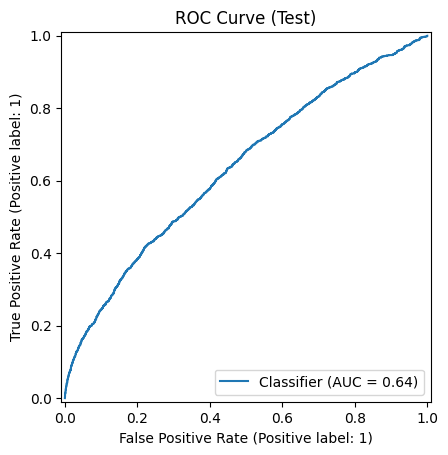

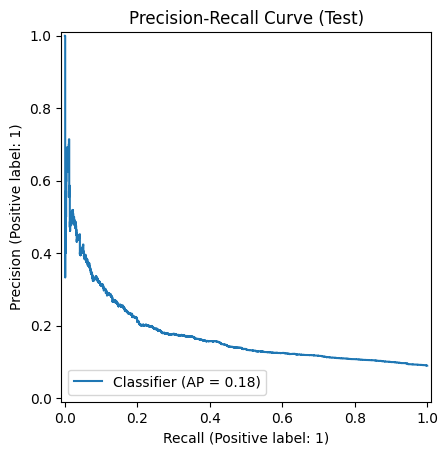

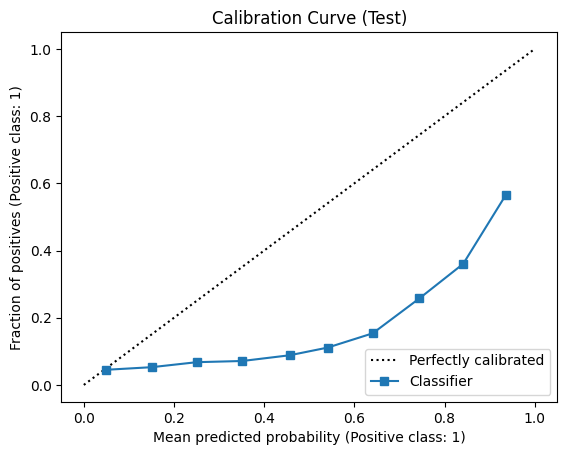

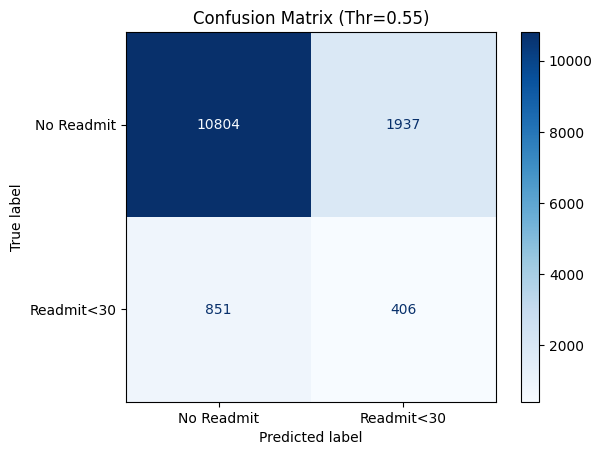

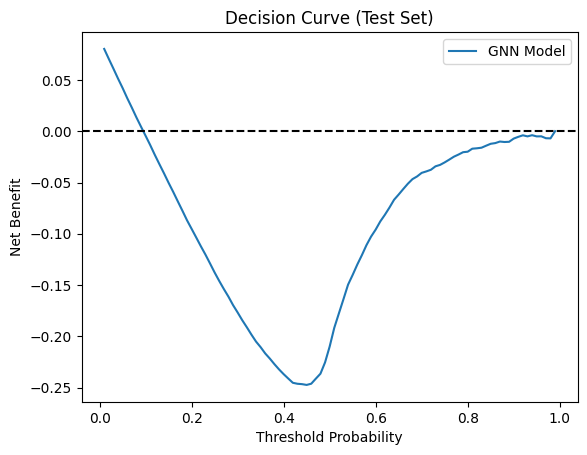

In [18]:
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay, ConfusionMatrixDisplay, confusion_matrix
from sklearn.calibration import CalibrationDisplay
# ROC Curve
RocCurveDisplay.from_predictions(test_labels, test_probs)
plt.title("ROC Curve (Test)")
plt.show()

# Precision-Recall Curve
PrecisionRecallDisplay.from_predictions(test_labels, test_probs)
plt.title("Precision-Recall Curve (Test)")
plt.show()

# Calibration curve (reliability diagram)
CalibrationDisplay.from_predictions(test_labels, test_probs, n_bins=10, strategy='uniform')
plt.title("Calibration Curve (Test)")
plt.show()

# Confusion Matrix at optimal threshold
cm = confusion_matrix(test_labels, test_pred_opt)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Readmit","Readmit<30"])
disp.plot(cmap="Blues")
plt.title(f"Confusion Matrix (Thr={best_thr:.2f})")
plt.show()

# Decision curve analysis (net benefit vs threshold)
from train.threshold import decision_curve_analysis
dc_df = decision_curve_analysis(test_labels, test_probs)
plt.plot(dc_df['threshold'], dc_df['net_benefit'], label='GNN Model')
plt.axhline(y=0, color='k', linestyle='--')
plt.xlabel("Threshold Probability")
plt.ylabel("Net Benefit")
plt.title("Decision Curve (Test Set)")
plt.legend()
plt.show()


In [38]:
from infer.batch_predict import batch_predict

# Suppose we have a CSV "raw/new_encounters.csv" of new patient encounters to predict
new_data_path = "raw/new_encounters.csv"
if os.path.exists(new_data_path):
    predictions_df = batch_predict(new_data_path, model, vocabs, config)
    logger.info(f"Inductive predictions saved to: {config.inference.output_predictions_path}")
    logger.info(predictions_df.head())


In [12]:
from benchmarks.baselines import train_and_eval_baselines
# Prepare NumPy arrays for baseline models
# Prepend "oh__" to categorical_low_card columns as they are likely one-hot encoded
oh_categorical_cols = ['oh__race_AfricanAmerican', 'oh__race_Asian',
       'oh__race_Caucasian', 'oh__race_Hispanic', 'oh__race_Other',
       'oh__gender_Female', 'oh__gender_Male', 'oh__gender_UNKNOWN',
       'oh__age_[0-10)', 'oh__age_[10-20)', 'oh__age_[20-30)',
       'oh__age_[30-40)', 'oh__age_[40-50)', 'oh__age_[50-60)',
       'oh__age_[60-70)', 'oh__age_[70-80)', 'oh__age_[80-90)',
       'oh__age_[90-100)', 'oh__max_glu_serum_>200', 'oh__max_glu_serum_>300',
       'oh__max_glu_serum_Norm', 'oh__A1Cresult_>7', 'oh__A1Cresult_>8',
       'oh__A1Cresult_Norm', 'oh__change_Ch', 'oh__change_No',
       'oh__diabetesMed_No', 'oh__diabetesMed_Yes']
feature_cols = config.data.columns.numeric  + oh_categorical_cols
X_train_tab = df_train[feature_cols].to_numpy()
y_train_tab = df_train[config.data.target.binarized_name].to_numpy()
X_val_tab = df_val[feature_cols].to_numpy()
y_val_tab = df_val[config.data.target.binarized_name].to_numpy()
X_test_tab = df_test[feature_cols].to_numpy()
y_test_tab = df_test[config.data.target.binarized_name].to_numpy()

print("Starting")
# Train and evaluate baseline models
baseline_results = train_and_eval_baselines(X_train_tab, y_train_tab, X_val_tab, y_val_tab, X_test_tab, y_test_tab, config=config)
print("Finishing")
# Display baseline evaluation results
for model_name, metrics_dict in baseline_results.items():
    test_met = metrics_dict["test"]
    logger.info(f"{model_name} - Test AUROC: {test_met.metrics['auroc']:.4f}, AUPRC: {test_met.metrics['auprc']:.4f}, "
                f"F1: {test_met.metrics['f1_pos']:.4f}, Precision: {test_met.metrics['precision_pos']:.4f}, Recall: {test_met.metrics['recall_pos']:.4f}, "
                f"Bal Acc: {test_met.metrics['balanced_accuracy']:.4f}")

Starting


TypeError: tuple indices must be integers or slices, not str

In [11]:
import torch
print("torch:", torch.__version__)      # e.g. 2.2.1
print("cuda :", torch.version.cuda)      # None==CPU, else like '12.1'


torch: 2.8.0+cu126
cuda : 12.6
